# An Introduction to Visualizing Astronomical Images

**Version 0.15**

This session has focused on image processing, with particular attention paid to how we make standard measurements (such as flux or position) in data taken with a wide-field survey, such as the Legacy Survey of Space and Time (LSST) to be conducted by the Vera C. Rubin Observatory. 



Of course, as every good astro-data scientist knows, you should: 

<div align="center">
<br>
<font size="+7"> WORRY ABOUT THE DATA </font>
</div>

For CCDs, that means *looking at the actual images*. 

This lecture is about the visualization of astronomical images. There are many different aspects that can (should?) be considered within this context. We will focus a primary principle of visualization (recall previous sessions):

  -  Salience - the most important aspects of the figure should stand out

As is often the case when it comes to image processing, Robert Lupton [(Lupton et al. 2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) has written some definitive text on building false color images (we will return to this later). 

* * *

Adapted by Bryan Scott, 2023, Jun 14 

Originally by Adam Miller (CIERA/Northwestern & Adler)
2020 July 13

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits

In [2]:
%matplotlib inline

If you have not already done so, 'git pull' to download the data. You should have

ztf_i_band.fits 

ztf_r_band.fits

ztf_g_band.fits

Some quick background: these images are taken from the [Zwicky Transient Facilty](https://www.ztf.caltech.edu/).\* ZTF has a 47 $\mathrm{deg}^2$ camera, with $\sim$1 arcsec pixels and $\sim$2 arcsec seeing. It has 3 filters (g, r, i) and has mapped most of the Northern hemisphere. Today we are working with ZTF stacks, roughly 16 individual images has gone into each of these stacks. 

## Problem 0) Why Luptitudes? 

**Feel free to skip this problem and move on to the coding exercises. It is included here to touch on some themes from the week so far.**

The quantity $$\mu = -a (\operatorname{arsinh}(x/2b) + ln(b)),$$ is called a luptitude and has a number of a nice properties that we will explore in this notebook. The goal of this problem is to understand why it is theoretically significant, and hence, why it can help to use these instead of traditional magnitudes, for example, in ML workflows. 

**Problem 0a)** Determine the limiting behavior of $\mu$ in the case where x goes to zero and x goes to $\infty$. 

**Problem 0b)** If we take m to be the limit as x goes to $\infty$, compute the variance in m and $\mu$, as well as the value of $m - \mu$.

**Problem 0c)** Comment on the tradeoff that one makes in picking a value of b. Is there an 'optimal' value? 

## Problem 1) Luminance

We begin by examining how we want to represent the intensity of the light as detected by the ZTF CCD.

**Problem 1a**

Load the data from `ztf_i_band.fits.gz` and display a 2D "heatmap" using [`imshow()`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.imshow.html).

*Note* - CCDs are linear detectors, so use a linear scaling (the default for `imshow()`) of the data in order to "see" what the detector sees.

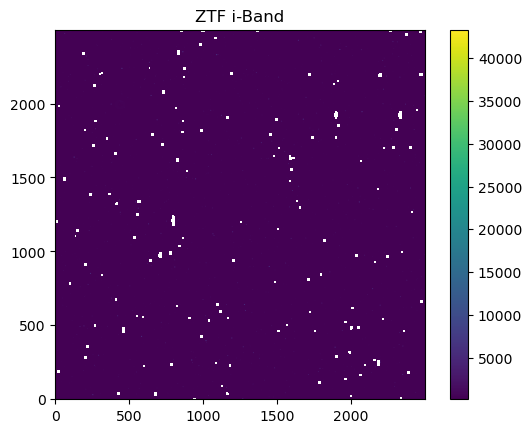

In [3]:
i_data = fits.getdata('./ztf_i_band.fits.gz')

# complete
plt.imshow(i_data, origin='lower')
plt.title('ZTF i-Band')
plt.colorbar()

The first thing that jumps out of this image is all the white pixels. They are $\equiv$ `nan` because they have been flagged in the ZTF image processing pipeline as unreliable/no good. 

Note - from an aesthic standpoint, you can make these disappear by inputting the following: 

`np.where(np.isnan(i_data), np.nanmedian(i_data), i_data)`

to `imshow()`, which replaces the nan values with the median value from the image. While this is aesthetically more pleasing, it is also misleading. Most of the masked pixels are saturated.

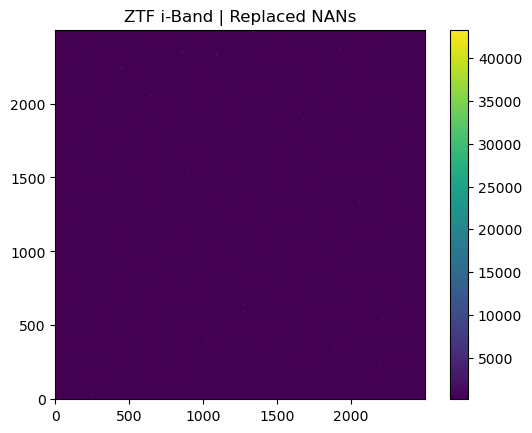

In [4]:
i_data_no_nans = np.where(np.isnan(i_data), np.nanmean(i_data), i_data)
plt.imshow(i_data_no_nans, origin='lower')
plt.title('ZTF i-Band | Replaced NANs')
plt.colorbar()

We can quickly see the problem with a linear scaling. The dynamic range is too large to reveal any significant structure in the data. We can see the brightest stars, but that is it.

We can adjust the bounds on the plotted distribution to better highlight the salient features in the data.

**Problem 1b**

Make a histogram of the counts in the image. If necessary, adjust the default settings to get a better sense of the distribution. 

*Hint* - be sure to input a 1D array, `i_data` is 2D.

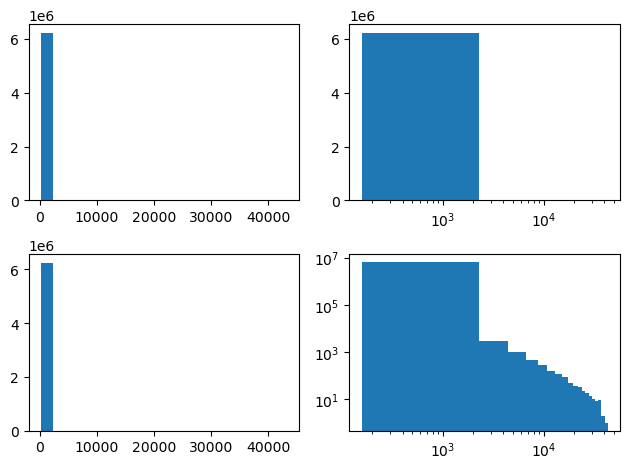

In [5]:
fig, ax = plt.subplots(2, 2, tight_layout=True) # complete   
N1, bins1, patches1 = ax[0,0].hist(i_data.flatten(), bins=20)
N2, bins2, patches2 = ax[0,1].hist(i_data.flatten(), bins=20)
# ax[0,1].set_xscale('log')
N3, bins3, patches3 = ax[1,0].hist(i_data_no_nans.flatten(), bins=20)
N4, bins4, patches4 = ax[1,1].hist(i_data_no_nans.flatten(), bins=20, log=True)
ax[0,1].set_xscale('log')
ax[1,1].set_xscale('log')

We can see a nearly logarithmic distribution, with nearly all the pixels near the "noise floor" of 175 or so, and a large tail to larger values.

Based on this histogram, we will clip the range we show to create better constrast in the visualization.

**Problem 1c**

Replot the i-band image while limiting the range that is displayed to extend from $m$ the minimum pixel value to $M$ the maximum pixel value. While it is possible to do this directly in `imshow()`, use `numpy` to limit the range of what is plotted (the utility of this will become clear later).

156.37813 43314.848


Text(0.5, 1.0, 'Linear | Limits')

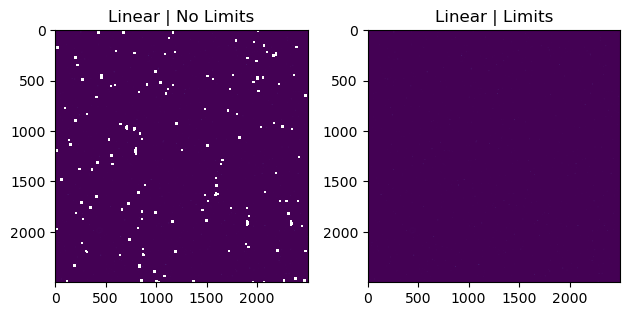

In [6]:
m = np.min(i_data_no_nans)
M = np.max(i_data_no_nans)

print(m, M)

fig, ax = plt.subplots(1, 2, tight_layout=True) # complete
im1 = ax[0].imshow(i_data)
im2 = ax[1].imshow(i_data_no_nans, vmin=m, vmax=M)
ax[0].set_title('Linear | No Limits')
ax[1].set_title('Linear | Limits')

# complete

Between these two examples we have seen the challenge of linear scales: 

(i) when featuring the full dynamic range they only feature "highlights" associated with the brightest pixels, 

(ii) when the the plotting range is limited then information about the brightest stars and galaxy cores is lost. 

**Problem 1d** 

Plot the i-band data using a log stretch. How does this compare to the linear stretch?

*Hint* – think about the salient features of the image. 

156.37813 43314.848


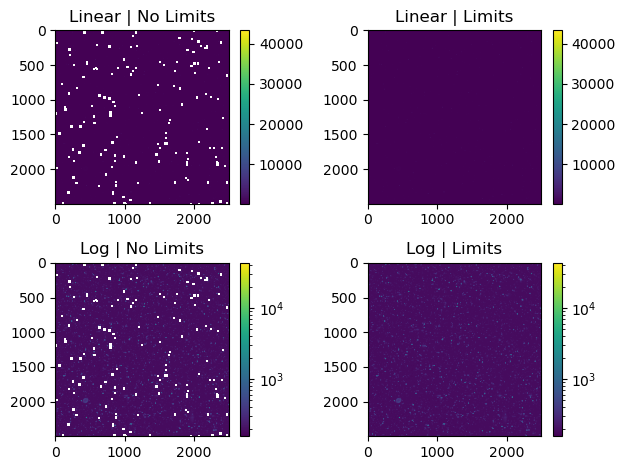

In [7]:
m = np.min(i_data_no_nans)
M = np.max(i_data_no_nans)

print(m, M)

fig, ax = plt.subplots(2, 2, tight_layout=True) # complete
im1 = ax[0,0].imshow(i_data)
im2 = ax[0,1].imshow(i_data_no_nans, vmin=m, vmax=M)
im3 = ax[1,0].imshow(i_data, norm=matplotlib.colors.LogNorm())
im4 = ax[1,1].imshow(i_data_no_nans, norm=matplotlib.colors.LogNorm())
ax[0,0].set_title('Linear | No Limits')
ax[0,1].set_title('Linear | Limits')
ax[1,0].set_title('Log | No Limits')
ax[1,1].set_title('Log | Limits')
fig.colorbar(im1, ax=ax[0,0])
fig.colorbar(im2, ax=ax[0,1])
fig.colorbar(im3, ax=ax[1,0])
fig.colorbar(im4, ax=ax[1,1])

# complete

Once again the brightest pixels dominate the range that is plotted, however, fainter structures are far more clear than with the linear stretch. 

It is also worth noting that the eye's response to intensity is roughly logarithmic\*. Therefore, plotting the data with a logrithmic stretch "mimics" what we actually see when looking up at the night sky.

\* This is the origin of the "magnitude" system, which is one of the worst units conventions in all of science. 

As before, we can do better by limiting the range that is displayed after the conversion to a log stretch. 

**Problem 1e**

Re-plot the i-band data with a log stretch and a cap on the minimum and maximum values to better highlight the "shadows" or faint structure within the data. 

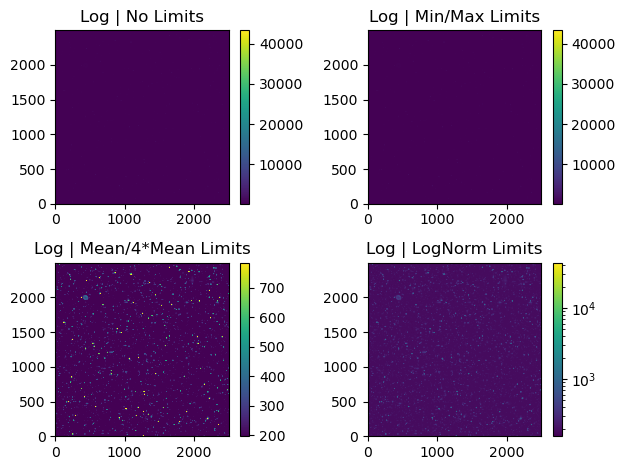

In [8]:
fig, ax = plt.subplots(2, 2, tight_layout=True) # complete
im1 = ax[0,0].imshow(i_data_no_nans, origin='lower')
im2 = ax[0,1].imshow(i_data_no_nans, vmin=m, vmax=M, origin='lower')
im3 = ax[1,0].imshow(i_data_no_nans, vmin=np.mean(i_data_no_nans), vmax=np.mean(i_data_no_nans)*4, origin='lower')
im4 = ax[1,1].imshow(i_data_no_nans, norm=matplotlib.colors.LogNorm(), origin='lower')
ax[0,0].set_title('Log | No Limits')
ax[0,1].set_title('Log | Min/Max Limits')
ax[1,0].set_title('Log | Mean/4*Mean Limits')
ax[1,1].set_title('Log | LogNorm Limits')
fig.colorbar(im1, ax=ax[0,0])
fig.colorbar(im2, ax=ax[0,1])
fig.colorbar(im3, ax=ax[1,0])
fig.colorbar(im4, ax=ax[1,1])

With the log scaling, we finally see the beautiful barred spiral galaxy to the northwest of the ring nebula. However, as was the case with the linear scaling, in order to see the spiral arms in the galaxy all the structure in the ring nebula gets blown out.

(There are also issues with log scaling when making false color images - we will come back to this.)

It is now generally accepted that the best scaling for CCD images is the [inverse hyperbolic sine](https://en.wikipedia.org/wiki/Inverse_hyperbolic_functions#Inverse_hyperbolic_sine). This non-linear transformation $$\operatorname{arsinh} x = \ln (x + \sqrt{x^2 + 1})$$ has the really nice property that for $|x| \ll 1$ $\operatorname{arsinh} x \approx x$ and for $|x| \gg 1$ $\operatorname{arsinh} x \approx \ln (2x)$. Therefore, with a single transformation we can get the best properties of each of the stretches condisered above. 

**Problem 1f**

Plot the i-band data with an inverse hyperbolic sine scaling.

In [9]:
asinh = np.log(i_data_no_nans + np.sqrt(i_data_no_nans**2 + 1))

['function', 'functionlog', 'linear', 'log', 'logit', 'symlog']

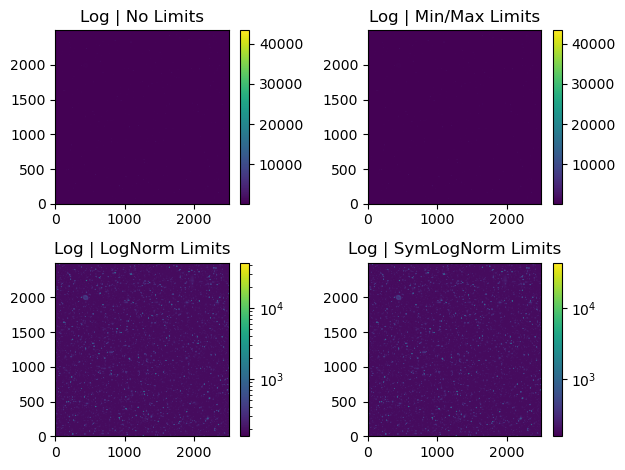

In [10]:
fig, ax = plt.subplots(2, 2, tight_layout=True) # complete
im1 = ax[0,0].imshow(i_data_no_nans, origin='lower')
im2 = ax[0,1].imshow(i_data_no_nans, vmin=m, vmax=M, origin='lower')
im3 = ax[1,0].imshow(i_data_no_nans, norm=colors.LogNorm(vmin=m, vmax=M), origin='lower')
im4 = ax[1,1].imshow(i_data_no_nans, norm=colors.SymLogNorm(linthresh=.001, vmin=m, vmax=M), origin='lower')
ax[0,0].set_title('Log | No Limits')
ax[0,1].set_title('Log | Min/Max Limits')
ax[1,0].set_title('Log | LogNorm Limits')
ax[1,1].set_title('Log | SymLogNorm Limits')
fig.colorbar(im1, ax=ax[0,0])
fig.colorbar(im2, ax=ax[0,1])
fig.colorbar(im3, ax=ax[1,0])
fig.colorbar(im4, ax=ax[1,1])

Off the shelf that looks pretty good. However we are missing some of the fainter structures. We can "re-center" the data so that the low-level shadows are closer to the $\sim$linear portion of the $\operatorname{arsinh}$ response curve.

**Problem 1g**

Subtract the median from the data and re-plot using an inverse hyperbolic sine scaling. 

*Hint* – do not forget about the `nan` values in the array.

In [ ]:
fig, ax = plt.subplots(# complete
    
# complete

And just like that we have the best looking image (by far!) with a relatively minimal amount of effort. In this representation the ring nebula is a little saturated/washed out. We can correct that with a softening parameter (more below). 

From **Problem 1** it is clear: the inverse hyperbolic sine is the best transform to use when displaying astronomical images. 

## Problem 2) Color


Color is not a particularly useful tool for conveying information when visualizing data. 

And yet...

When it comes to 2D CCD images, simply put, color wins.\*

<br>

\* With the important and glaring exception that the standard RGB format is not color-blind friendly, and therefore color images are not always inclusive. 

For example, this  image with intensity information shows some stars and galaxies (and not much more). 

 

<img style="display: block; margin-left: auto; margin-right: auto" src="images/false_color_intensity.png" align="middle">

<div align="right"> <font size="-3">(credit: Zolt Levay/STScI) </font></div>

Whereas the RGB version immediately reveals a high-$z$ quasar. (So this isn't just about "pretty pictures" we are using color to better communicate what we are looking at.)

<img style="display: block; margin-left: auto; margin-right: auto" src="images/false_color_RGB.png" align="middle">

<div align="right"> <font size="-3">(credit: Zolt Levay/STScI) </font></div>

Suppose you have data in 3 filters (e.g., g, r, i) and you wish to make a false color image. DSFP "best-practices" would suggest optimizing the luminance display for each filter and then showing them side by side (this is the colorblind-friendly solution):


<img style="display: block; margin-left: auto; margin-right: auto" src="images/false_color_1.png" align="middle">

<div align="right"> <font size="-3">(credit: Zolt Levay/STScI) </font></div>

You could even play with the color scheme slightly to be more subjective (while remaining colorblind-friendly):



<img style="display: block; margin-left: auto; margin-right: auto" src="images/false_color_2.png" align="middle">

<div align="right"> <font size="-3">(credit: Zolt Levay/STScI) </font></div>

But in combination it becomes possible to truly pick out structure (such as H$\alpha$ emission, traced by red in this instance):

<img style="display: block; margin-left: auto; margin-right: auto" src="images/false_color_3.png" width="550" align="middle">

<div align="right"> <font size="-3">(credit: Zolt Levay/STScI) </font></div>

Following the suggestions laid out in [Lupton et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) we will now make a false color vizualization of the ring nebula using the ZTF g,r,i reference images. 

**Problem 2a**

Load the data from the g- and r-band images, and store it in variables named `g_data` and `r_data` respectively.

In [ ]:
g_data = fits.getdata('ztf_g_band.fits.gz')
r_data = fits.getdata('ztf_r_band.fits.gz')

To display an RGB color image with `imshow()` we need to create an MxNx3 array, where MxN is the size of the image, and the last axis corresponds to the red, green, and blue channels respectively. 

Building this 3D array is simple using [`numpy.dstack()`](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html).

**Problem 2b**

Build an RGB array of the ZTF images and display the data using `imshow()`.

In [ ]:
rgb = # complete
fig, ax = plt.subplots( # complete

# complete

That looks terrible! 

As the warning states, RGB data needs to be scaled from 0 to 1 (or 0 to 255 for integer inputs) in order to properly display the relative intensities in each channel. 

**Problem 2c**

Build a helper function `scaled_intensity()` that takes as input 3 MxN arrays, and returns an MxNx3 array in which the input arrays have all been rescaled between 0 and 1. 

Use your function to display a false color image of the ring nebula.

*Hint* –– here (and below) it may be helpful to write a solution in multiple cells. 

In [ ]:
def scaled_intensity( # complete
    '''
    Linearly scale input RGB arrays from 0 ---> 1
    
    Parameters
    ----------
    R_array : array-like of shape (M columns, N rows)
        R channel data array

    G_array : array-like of shape (M columns, N rows)
        G channel data array

    B_array : array-like of shape (M columns, N rows)
        B channel data array

    Returns
    -------
    rgb_scaled : array-like of shape (M columns, N rows, 3)
        RGB array for display with matplotlib
    '''
    
    r_scaled = # complete

    g_scaled = # complete

    b_scaled = # complete
    
    rgb_scaled = # complete
    
    return # complete

In [ ]:
fig, ax = plt.subplots( # complete
    
# complete

As before, there are few pixels bright enough over the full scale of the image to see any real structure in the data (though you can make out hints of the ring nebula in this otherwise awful image).

There are two ways to address this and we will do both: (i) use a different scaling, such as $\log$, and (ii) limit the full plotting range.

**Problem 2d**

Write a new (but very similar to **2c**) function called `scaled_log_intensity()` that returns the log of the flux (to better highlight faint features), scaled from 0 to 1 (to allow output as an RGB image). Plot the newly scaled rgb array.

In [ ]:
def scaled_log_intensity( # complete
    '''
    Log scale input RGB arrays from 0 ---> 1
    
    Parameters
    ----------
    R_array : array-like of shape (M columns, N rows)
        R channel data array

    G_array : array-like of shape (M columns, N rows)
        G channel data array

    B_array : array-like of shape (M columns, N rows)
        B channel data array

    Returns
    -------
    rgb_scaled : array-like of shape (M columns, N rows, 3)
        RGB array for display with matplotlib
    '''
    
    # complete
    # complete
    # complete

In [ ]:
fig, ax = plt.subplots( # complete
# complete
# complete

Now the ring nebular stands out, (AND the color is telling us something, the strong green color reflects strong emission from $\mathrm{H}\alpha$ in the outer layers of the nebular, while the blue center is the result of [O III] emission), however, there is very little information being transmitted by the rest of the image. We can improve this by adding limits to the plotting range. 

**Problem 2e**

Modify `scaled_log_intensity()` to "clip" each array at a maximum and minimum value. Replot your RGB array after clipping.

*Hint* – in principle this means six new variables should be added to the function (r_min, r_max, g_min, g_max, b_min, b_max). For now, use the same lower and upper bound for all 3 filters for simplicity. `np.percentile()` is a decent way to do this uniformly across all 3 filters. 

In [ ]:
def scaled_log_intensity( # complete
    '''
    Log scale input RGB arrays from 0 ---> 1
    
    Parameters
    ----------
    R_array : array-like of shape (M columns, N rows)
        R channel data array

    G_array : array-like of shape (M columns, N rows)
        G channel data array

    B_array : array-like of shape (M columns, N rows)
        B channel data array

    # complete : # complete
        # complete
    
    # complete : # complete
        # complete

    Returns
    -------
    rgb_scaled : array-like of shape (M columns, N rows, 3)
        RGB array for display with matplotlib
    '''
    
    # complete
    # complete
    # complete

In [ ]:
fig, ax = plt.subplots(# complete
# complete
# complete

We have a false color image! The problem, as highlighted in Lupton et al. 2004, is that the "standard" log scaling of each channel leads to the cores of each of the individual stars appearing as a whitish color. While we have a false color image, we have actually lost all the color information.

## Problem 3) Lupton et al. (2004)

As the Sloan Digital Sky Survey began producing multi-filter wide-field images at an "industrial" scale, it was quickly realized that superior solutions were needed for visualizing the 5 filter images (in particular, the use of "log" scaling dramatically reduced the information content). 

Lupton et al. proposed a solution that has now been widely adopted. Half of the solution is to use $\operatorname{arsinh}$, and the other half is to be clever about defining the relative color in each pixel (perhaps the most useful insight from Lupton et al.). 

We start by defining the intensity in each pixel $I \equiv (r + g + b)/3$, where the $r$, $g$, and $b$ values are the value in each pixel of the R(ed), G(reen), and B(lue) images, respectively. Then the output false color image can be defined by:

$$R = r f(I)/I, \\ G = g f(I)/I, \\ B = b f(I)/I,$$

where $f(I)$ is some scaling function, such as $\log$ or $\operatorname{arsinh}$.

As a final step the intensity in each filter is also clipped (which allows the preservation of color information even in pixels that have an intensity = 1; this is a hugely important insight). If 

$$\mathrm{max_{RGB}} \equiv \mathrm{max(R,G,B)} > 1$$

then we need to set $R \equiv R/\mathrm{max_{RGB}}, G \equiv G/\mathrm{max_{RGB}},$ and $B \equiv B/\mathrm{max_{RGB}}$, similarly if $\mathrm{min_{RGB}} \leq 0$ then set $R \equiv G \equiv B \equiv 0$. 

Finally, Lupton et al. point out that a useful parameterization of $f(I)$ is: $$f(I) = \operatorname{arsinh}(\alpha Q [I-m])/Q,$$ where $Q$ and $\alpha$ are both "softening" parameters that enable the user to highlight specific regions within the image with a linear stretch (and $m$ is the minimum for the plotting range as described earlier). 

In summary, in order to obtain the "optimal" RGB scaling as described in Lupton et al. we must 
  
  (i) create a total intensity map for each pixel $I$, 
  
  (ii) apply an $\operatorname{arsinh}$ transform to all the data, and 
  
  (iii) rescale the intensity to be clipped at unity (but in such a way that preserves color information in the clipped pixels) and zero. 

(In true DSFP fashion,) We will build this functionality one step at a time, but ultimately we want a single function that can take 3 input arrays and output a nice RGB array for plotting.

**Problem 3a**

Create a function `tmp_lupton_1` that takes as input 3 MxN arrays, computes the intensity array $I$, and returns an MxNx3 array in which the input arrays have been divided by I *AND* rescaled between 0 and 1. (we will add $\operatorname{arsinh}$ in a later step)

*Hint* – you can plot the results, but they won't be very compelling.

In [ ]:
def tmp_lupton_1( # complete
    '''
    normalize intensity and scale input RGB arrays from 0 ---> 1
    
    Parameters
    ----------
    R_array : array-like of shape (M columns, N rows)
        R channel data array

    G_array : array-like of shape (M columns, N rows)
        G channel data array

    B_array : array-like of shape (M columns, N rows)
        B channel data array

    Returns
    -------
    rgb_scaled : array-like of shape (M columns, N rows, 3)
        intensity scaled RGB array for display with matplotlib
    '''
    
    # complete
    # complete
    # complete

**Problem 3b**

Create a new function `tmp_lupton_2` that does everything in `tmp_lupton_1` but *also* mutliplies the individual arrays by $f(I)$ as defined above. There will be 3 new parameters in the model now: $m$, $Q$, and $\alpha$.

In [ ]:
def tmp_lupton_2( # complete
    '''
    arsinh intensities scaled to RGB arrays from 0 ---> 1
    
    Parameters
    ----------
    R_array : array-like of shape (M columns, N rows)
        R channel data array

    G_array : array-like of shape (M columns, N rows)
        G channel data array

    B_array : array-like of shape (M columns, N rows)
        B channel data array
    
    # complete : # complete
        # complete
    
    # complete : # complete
        # complete
        
    # complete : # complete
        # complete

    Returns
    -------
    rgb_scaled : array-like of shape (M columns, N rows, 3)
        intensity scaled RGB array for display with matplotlib
    '''
    
    # complete
    # complete
    # complete

**Problem 3c**

Use `tmp_lupton_2` to rescale the ZTF data and plot the results.

*Hint* – if the results appear a little underwhelming, do not forget to subtract the median value from the input arrays.

In [ ]:
fig, ax = plt.subplots( # complete 
# complete

You should already see a huge improvement relative to the $\log$ scaled false color image that was produced in **Problem 2**. Further improvements can still be made, however. For instance, the background is a little "muddy" in the sense that everything looks a little brown instead of black.

**Problem 3d**

Create a new function `lupton` that does everything in `tmp_lupton_2` but *also* clips and normalizes data with $I \equiv 0$ or $\mathrm{max_{RGB}} > 1$.

In [ ]:
def lupton( # complete
    '''
    arsinh intensities scaled to RGB arrays from 0 ---> 1
    
    Parameters
    ----------
    R_array : array-like of shape (M columns, N rows)
        R channel data array

    G_array : array-like of shape (M columns, N rows)
        G channel data array

    B_array : array-like of shape (M columns, N rows)
        B channel data array
    
    # complete : # complete
        # complete
    
    # complete : # complete
        # complete
        
    # complete : # complete
        # complete
        

    Returns
    -------
    rgb_scaled : array-like of shape (M columns, N rows, 3)
        intensity scaled RGB array for display with matplotlib
    '''
    
    # complete
    # complete
    # complete

    # complete
    # complete
    # complete

    # complete
    # complete
    # complete

In [ ]:
fig, ax = plt.subplots( # complete
    
# complete

That looks worse than what we had before! 

However - we have not attempted to tune the visualization parameters at all (and the default values in the solutions, namely $Q = 1$ and $\alpha = 1$ are attrocious.

**Problem 3e**

Re-plot the ZTF data after adjusting the tuning parameters $m, Q, \mathrm{and} \alpha$. Expect some trial and error.

*Hint* –– a footnote in [(Lupton et al. 2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) suggests setting $Q \rightarrow 0$ to tune $\alpha$ in such a way to highlight faint structures, then adjusting $Q$ to highlight the bright regions in the image.

*Hint 2* –– it is very likely that your initial "solution" will appear overly "green." This is because the color-balance is off. One secret about creating such images is that you are allowed to play with the relative intensities of the R, G, and B channels. This is a *False* color image, after all. If you want something that appears less "green" try multiplying the B or R channel (or both) by some constant $> 1$ to get a color balance you prefer. The optimal solution maximizes the salience of your final image.

In [ ]:
fig, ax = plt.subplots( # complete

# complete

Wow! 

This image of the Ring nebular and the nearby spiral is really nice. The background is black. The stars are not saturated (in the sense that it is extremely easy to tell the difference between the red stars and blue stars). Structure in the ring nebular can be seen (though the outermost halo is missing, see e.g., **3c**). And the nearby barred-spiral looks especially good. The nucleus is somewhat orange, suggesting an older stellar population, while the arms are clearly blue (and therefore forming stars at a higher rate than the nucleus).

This is a very very nice depiction of the ring nebula.

## Problem 4) Astropy

As is often the case, the good people at [`astropy`](https://www.astropy.org/) have already created a helper function that essentially does everything that we just developed in this notebook. In this case, with the `astropy.visualization` library there is a function called [`make_lupton_rgb`](https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html?highlight=make_lupton_rgb) that takes as input 3 MxN arrays, and returns a scaled MxNx3 rgb array for display purposes.

**Problem 4a**

Load `make_lupton_rgb` and make a plot of the results. How does it compare to your own solution?

*Hint* –– the `make_lupton_rgb` function uses a parameter called `stretch` instead of $\alpha$. As you tune the output note that $\mathrm{stretch} \approx 1/\alpha$.

In [ ]:
from astropy.visualization import make_lupton_rgb

rgb = make_lupton_rgb( # complete
fig, ax = plt.subplots( # complete

This is an extremely similar solution to what we derived. 

The stars all more or less look the same, though the outer outer halo of the ring nebular is now more clear (at the cost of saturating the inner $\mathrm{H}\alpha$ ring). 

**Problem 4b**

*This is optional* In the cell below images from SDSS are loaded. Use `make_lupton_rgb` to create a false color RGB image. The star formation rate in the three main galaxies in the image are actually somewhat different, see if you can highlight that. 

In [ ]:
from astropy.utils.data import get_pkg_data_filename

# Read in the three images downloaded from here:
g_name = get_pkg_data_filename('visualization/reprojected_sdss_g.fits.bz2')
r_name = get_pkg_data_filename('visualization/reprojected_sdss_r.fits.bz2')
i_name = get_pkg_data_filename('visualization/reprojected_sdss_i.fits.bz2')
g_dat = fits.open(g_name)[0].data
r_dat = fits.open(r_name)[0].data
i_dat = fits.open(i_name)[0].data

# complete
# complete
# complete

## Challenge Problem

Section 3 in [(Lupton et al. 2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) provides a solution for dealing with saturated/masked pixels. Implement that solution to create a nicer visualization of the ring nebular that does not feature so many `nan` values.